## Exploring the Likelihood of Topological Change Upon GA Performance

This notebook will explore the effect had by stochastic topological changes with different probabilties to occuring at each time step upon the performance of the GA using the best performing HIGA as a representative. 

In [6]:
import time 
import random
import numpy as np
import itertools
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt
import heapq

In [7]:
# ***
# Generate Log-Normal Distributed Graph 
# Generate coordinates for n nodes 
# n: Number of nodes 
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

# Calculate the straight line distance between coordinates  
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair 
# b: Second coordinate pair 
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

def depth_factor(i, j):
    return np.exp(-pythag(i, j))

def surface_factor(si, sj):
    return (si + sj)

def nx_log_normal(size, degree):
    # Generate coordinates in range [0, 1]
    scale = 1
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node 
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define the surface factor between every node pair 
    # Larger surfaces have greater probability to connect 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
    
    # Define the depth factor between every pair of nodes 
    # Geometrically closer nodes have higher depth factor 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Calculate the existence probability for each edge 
    # depth_factor_ij * surface_factor_ij 
    ep = np.multiply(df, sf)
    total_ep = np.sum(ep)
    
    # Roulette wheel 
    # Create an edge (i, j) with Pr. proportional to ep_ij 
    edges_set = []
    
    while degree > 0:
        pr_sum = 0.0 
        ptr = random.random()
        
        for i, j in itertools.product(range(size), range(size)):
                if i == j:
                    continue 
                
                pr = ep[i][j] / total_ep
                pr_sum += pr 
                
                if pr_sum > ptr: 
                    edges_set.append((i, j, {'weight': pr}))
                    break
        
        degree = degree - 1 
    
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(edges_set)
    
    return G 

# Get a connected log normal 
def connected_log_normal(size, degree):
    # Set a hard limit on the number of models generated
    # before exit
    max_iterations = 100
    
    # Generate models until connected
    for i in range(max_iterations):
        G = nx_log_normal(size, degree)
        
        # Check if G is connected 
        connected = True
        for node in range(size):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return G
    
    # Return the false flag and null model
    return None 


# ***
# Generate Barabasi-Albert Model 
def barabasi_albert_node(G, n):
    # Node & Degree for each node in G excluding new node 
    degree = [d for (n, d) in G.degree]
    # Probability for each node 
    # There are no edges from node n 
    pr = np.divide(degree, (2 * len(G.edges())))
    
    return np.random.choice(G.nodes(), p = pr)


def barabasi_albert_edge(G, n): 
    dest = barabasi_albert_node(G, n)
    edge = (n, dest)
    
    # Recurse to add new non-existing edge 
    if edge in G.edges():
        barabasi_albert_edge(G, n)
        return
    
    # Avoid self-edges
    # Self edges should not occur (probability to choose n is zero)
    # However, they do appear in this implementation FIX LATER
    if n == dest:
        barabasi_albert_edge(G, n)
        return
    
    G.add_edge(n, dest)
    
# Produce a scale-free network represented as a networkx graph 
#    object with initial size m and final size n
# m: Initial size of graph
# n: Final size of graph 
# return: Networkx graph model 
def barabasi_albert(m, n):
    # Begin with a fully connected graph size m
    G = nx.complete_graph(m)
    
    for n in range(m, n):
        G.add_node(n)
        
        # Connect new node to m existing nodes 
        for i in range(m):
            barabasi_albert_edge(G, n)
    
    return G 


# ***
# Generate a Watts-Strogatz Networkx graph 
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges

def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)
            
# Generate a networkx graph with small world properties (Watts-Strogatz)
def watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring


# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w = None):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w
            
            
def weighted_watts_strogatz(n, k, p):
    g = watts_strogatz(n, k, p)
    assign_random_weights(g, 0, 100)
    return g 


def weighted_log_normal(size, degree):
    g = connected_log_normal(size, degree)
    assign_random_weights(g, 0, 100)
    return g

def weighted_barabasi_albert(m, n):
    g = barabasi_albert(m, n)
    assign_random_weights(g, 0, 100)
    return g

In [30]:
class GA:
    # CLASS WIDE PROPERTIES 
    # Reproduction rate (half of population used as parents)
    R_RATE = 0.5 
    
    # ***
    # Constructor 
    def __init__(self, ITERATIONS = 30, THRESHOLD = 12, 
                    P_SIZE = 100, M_RATE = 0.03, RI = 0.1, 
                EI = 0.1, IM = 0.8):
        self.ITERATIONS = ITERATIONS
        self.THRESHOLD = THRESHOLD 
        self.P_SIZE = P_SIZE
        self.M_RATE = M_RATE
        
        # Flag which immigrant scheme to use 
        self.flag_riga = False
        self.flag_eiga = False
        
        # Immigrant scheme variables 
        self.RI = RI   # Proportion of population replaced with Random Immigrants
        self.EI = EI   # Proportion of population replaced with Elitist Immigrants 
        self.IM = IM   # Probability to mutate elitist immigrant 
        
        # Graph
        self.G = None 
        self.src = 0 
        self.dst = 0
        
        # Generation Variables 
        self.reset_generation() 
    
    
    # ***
    # Setter methods for RIGA/EIGA/HIGA configuration 
    def set_riga(self):
        self.flag_riga, self.flag_eiga = True, False 
    
    def set_eiga(self):
        self.flag_riga, self.flag_eiga = False, True 
        
    def set_higa(self):
        self.flag_eiga, self.flag_riga = True, True 
    
    def set_standard(self):
        self.flag_eiga, self.flag_riga = False, False 
    
    def set_mode(self, mode):
        if mode == "eiga":
            self.set_eiga()
        elif mode == "riga":
            self.set_riga()
        elif mode == "higa":
            self.set_higa()
        elif mode == "standard":
            self.set_standard()
        else:
            return 
    
    
    # ***
    def path_length(self, p):
        return sum(self.G[i][j]['weight'] for i, j in zip(p, p[1:]))
    
    # ***
    # Return fitness given path and graph 
    def fit(self, p):
        # Zero fitness for invalid path 
        if not nx.is_path(self.G, p):
            return 0

        # Fitness for valid path 
        return self.path_length(p) ** (-1)
    
    
    # ***
    # Function to define a single new random path from node s to node r
    # in a network supplied as a Networkx graph 
    # G: Graph / network as networkx
    # s: Start node 
    # r: Destination node 
    def gen_path(self, s, r):
        path = [s]
        
        current = s
        while current != r: 
            # Neighbours exluding nodes in path 
            neighbours = [n for n in self.G[current] if n not in path]

            # Sometimes, neighbours is empty 
            # In which case, retry 
            if not neighbours:
                return self.gen_path(s, r)

            # Select neighbour node with uniform probability  
            nxt = np.random.choice(neighbours) 

            # List and visit next node 
            path.append(nxt)
            current = nxt 

        return path
    
    
    # ***
    # Function to generate a population of n random paths s->r
    # G: Graph as networkx
    # s: Start node
    # r: Destination node
    # n: Number of paths / size of population 
    def gen_population(self, size):
        population = []
        for i in range(size):
            # Generate a new candidate path
            candidate = self.gen_path(self.src, self.dst)
            # Generate a new candidate 
            population.append(candidate)
        
        return population 
    
    
    # ***
    # Perform crossover between two paths s->r
    # The two paths must have at least one common element 
    # From the set of common elements, one is selected, v 
    # The paths are redifined as s -> v, v -> r  
    # The path segments are recombined to create two children
    # a: The first path
    # b: The second path 
    def crossover(self, a, b):
        common = [] 
        for ind_a, i in enumerate(a):
            for ind_b, j in enumerate(b):
                if i == j:
                    common.append((ind_a, ind_b))

        # Randomly select a one common element to exchange
        target = np.random.choice(len(common))

        # Retrieve indexes
        ind_a, ind_b = common[target]

        # Create new arrays
        chd_a = a[:ind_a] + b[ind_b:]
        chd_b = b[:ind_b] + a[ind_a:]

        return chd_a, chd_b
    
    
    # ***
    # Updated mutation function 
    # Deal with possibility that elements of path no longer exist, 
    # except for src and dst 
    def mutate(self, path):
        indexes = np.random.choice((len(path) - 1), size = (len(path) - 1), replace = False)
        
        ind = -1
        for i in indexes:
            if self.G.has_node(path[i]):
                ind = i 
        
        # Create a new random path from v to destination 
        v = path[ind]
        rnd_path = self.gen_path(v, self.dst)

        return path[:ind] + rnd_path
    
    
    # ***
    # Compute the fitness value of each hypotheses 
    # p: Population
    # g: Graph 
    # Return: fitness list, maximum fitness value, sum of fitness values 
    def evaluate(self, p):
        # Evaluate the fitness of the population 
        fitness = [self.fit(h) for h in p]

        return fitness, max(fitness), sum(fitness), mean(fitness)
    
    
    # ***
    # Stochastic universal selection 
    #     - Uses a single random value to sample all solutions 
    # n: Number of hypotheses to select
    # population: Population of hypotheses
    # fitness: Fitness array
    # ftotal: Sum of fitness values 
    # target: Target array to append selected hypotheses 
    def stochastic_universal(self, n, target):
        step = self.ftotal / n                       # Size of selection bins 
        start = random.uniform(0, step)     # Random in range [0, step)

        # Each pointer value indicates a selection threshold
        # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
        pointers = [(start + (i * step)) for i in range(0, n)]

        for ptr in pointers:
            ind = 0               # Current index 
            running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)

            # Until the threshold is exceeded 
            while running_sum < ptr: 
                running_sum += self.fitness[ind]
                ind += 1 

            target.append(self.population[ind - 1])
    
    
    # ***
    # Set all generation parameters to zero/empty/none before
    # initialisation and beginning a new run 
    def reset_generation(self):
        self.start, self.end = 0, 0
        
        # GA Variables 
        self.elite = []
        self.fitness = []
        self.population = [] 
        
        # Generation stats
        self.generation_count = 0 
        self.num_stable_generations = 0 
        self.fmax, self.favg, self.ftotal = 0, 0, 0

        self.history = {"max": [], "avg": []}
    
    
    # ***
    # Function to initialise the population 
    # with starting graph G, src and destination 
    def initialise(self, G, src, dst):
        self.G = G.copy() 
        self.src = src
        self.dst = dst
        
        # Reset stats
        self.reset_generation()
        
        # Generate a random population 
        # Graph; start node; dest node; size of population 
        self.population = self.gen_population(self.P_SIZE) 
        self.fitness, self.fmax, self.ftotal, self.favg = self.evaluate(self.population)
        
        # Initialise previous generation elite at P(0) 
        self.elite = self.population[np.argmax(self.fitness)]
    
    
    # ***
    # Return the best candidate in current population 
    def get_best_candidate(self): 
        if (not self.fitness) or (not self.population):
            return [] 
        
        ind = np.argmax(self.fitness)
        best = self.population[ind]
        return (self.path_length(best), 
                self.fitness[ind], best)
        
        
    # ***
    # Get performance results from current generation 
    def get_results(self):
        # Return stats and performance 
        length, fit, best = self.get_best_candidate()
        runtime = self.end - self.start 
        
        results = {"generations": self.generation_count, 
                   "runtime": runtime,
                   "history": self.history, 
                   "solution": best, 
                   "length": length, 
                   "fitness": fit}
        
        return results 
    
    
    # *** 
    # Generate elitist immigrants from P(t-1)
    def gen_ei(self, gen):
        ei_list = []
        n_ei = int(self.EI * self.P_SIZE)

        # Generate ei*p elitist immigrants 
        for i in range(n_ei):
            # Mutate elite from p(t - 1)
            if random.random() < self.IM:
                ei_list.append(self.mutate(self.elite)) 
            else:
                ei_list.append(self.elite)

        return ei_list 
    
    
    # ***
    # Generate random immigrants
    def gen_ri(self, gen):
        n_ri = int(self.RI * self.P_SIZE)
        return self.gen_population(n_ri)
    
    
    # ***
    # Run a single generation of GA 
    def run_generation(self):
         # Append to training history 
        self.history["max"].append(self.fmax)
        self.history["avg"].append(self.favg)
        
        # Create new generation 
        gen = [] 
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - self.R_RATE) * self.P_SIZE)
        self.stochastic_universal(num_hypotheses, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(self.R_RATE * self.P_SIZE) 
        self.stochastic_universal(num_parents, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            e, f = self.crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(e) 
            gen.append(f)
            
        # Choose m percent of new population uniformly to mutate 
        m_size = int(self.M_RATE * self.P_SIZE)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = self.mutate(gen[i]) 
            
        # *** BEGIN HIGA SCHEME ***
        
        # Evaluate interim population 'gen'
        (gf, gmax, gtotal, gavg) = self.evaluate(gen)
        
        immigrants = [] 
        
        # If EIGA is true 
        if self.flag_eiga:
            # Check that elite immigrant is still valid E(t - 1)
            # If not, then use current best as new elite 
            if not nx.is_path(self.G, self.elite):
                # Re-evaluate current population to get new elite
                temp_fitness = self.evaluate(self.population)[0]
                # Use current best instead 
                ind = np.argmax(temp_fitness)
                self.elite = self.population[ind]
            
            immigrants = immigrants + self.gen_ei(immigrants)
        
        if self.flag_riga:
            immigrants = immigrants + self.gen_ri(immigrants)
    
        # Replace the ri*p worst candidates with immigrants 
        # O(n log k) to find k smallest elements in array of n 
        #   - Use min heap of size k, compare each element to heap min, i
        #        if smaller then remove max and replace 
        n_immigrants = len(immigrants)
        if n_immigrants:
            heap = []
            for i in range(n_immigrants):
                # Tuple (fitness, index) and order heap on first element
                heapq.heappush(heap, (-(gf[i]), i)) 
            heapq.heapify(heap)

            # Add smaller elements and maintian heap 
            for i in range(n_immigrants, len(gen)):
                if -(gf[i]) < heap[0][0]:
                    heap[0] = heap[-1]
                    heap.pop()
                    heap.append(((-gf[i]), i))
                    heapq.heapify(heap)

            # Replace worst candidates 
            for i in range(n_immigrants):
                ind = heap[i][1]
                gen[ind] = immigrants[i]
    
            # Set elite 
            # Elite is best of P(t - 1), 
            # Each generation G(t) works on P(t) to Generate P(t + 1)
            self.elite = self.population[np.argmax(self.fitness)]
    
        # *** END of HI SCHEME *** 
        
        # Population equal to copy of generation 
        self.population = list(gen) 
        
        # Evaluate the new population fitness
        _fmax = self.fmax
        self.fitness, self.fmax, self.ftotal, self.favg = self.evaluate(self.population)
        
        # Check if maximum fitness solution has changed 
        if _fmax == self.fmax:
            self.num_stable_generations += 1 
        else:
            # Reset when max fitness changes 
            self.num_stable_generations = 0 
        
        # Increment generation count
        self.generation_count += 1 
        
    
    # ***
    def get_generation_stats(self):
        return (self.fitness, self.fmax, self.favg)
        
        
    # ***
    # Run full GA to ITERATIONS or THRESHOLD 
    def run(self):
        self.start = time.time()
        while (self.num_stable_generations < self.THRESHOLD) and (self.generation_count < self.ITERATIONS):
            self.run_generation()
        self.end = time.time()
    
    
    # ***
    def set_iterations(self, itr):
        self.ITERATIONS = itr 
    
    
    # ***
    def set_threshold(self, thr):
        self.THRESHOLD = thr
        

    # ***
    def set_graph(self, graph):
        self.G = graph.copy() 
        
        
    def get_history(self ):
        return self.history

**Dynamics**

In [9]:
# With Probability Pr randomly rewire each edge to a new destination node
# Destination node must not be self, or already connected 
# G: Networkx Graph
# pr: Probability to rewire 
def dynamic_step_EDGE(G, pr = 0.0):
    # For all edges 
    for i, j in G.edges():
        # With probability Pr 
        if random.random() < pr:            
            weight = G[i][j]['weight']
            
            if G.degree[j] == 1:
                continue 
                
            # Rewire the edge to from j to v
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v, weight=weight)


# ***
def dynamic_step_WEIGHT(G, Pr, minw = 0, maxw = 100):
    # For each edge and weight
    for i, j, w in G.edges(data = True):
        if random.random() < Pr:
            G[i][j]['weight'] = np.random.uniform(minw, maxw)

        
# ***
def dynamic_step_NODE(G, Pr, avoid, minw = 0, maxw = 100):
    removed = []
    G_ = G.copy()
    
    reconnect = []
    # Randomly remove nodes
    for node in list(G_.nodes()):
        if random.random() < Pr:
            # 
            if node in avoid:
                continue 
                
            # Check if any nodes need to be reconnected
            for j in G_[node]:
                if G_.degree[j] == 1:
                    reconnect.append(j) 
            
            G_.remove_node(node)
            removed.append(node)
    
    # Reconnect lonely, disconnected nodes 
    for j in reconnect:
        if j in G_.nodes():
            i = np.random.choice(G_.nodes())
            G_.add_edge(j, i, weight = random.uniform(minw, maxw))
        
    return (G_, removed) 

**Simulation**

In [36]:
# ***
# Experiment function producing results for one plot 
# Node set 
def experiment_node(ga, g, src, dst, generations, Pr_list):
    # Work with a copy of the passed graph 
    G_ = g.copy() 
    ga.set_higa()
    
    results = [] 
    for Pr in Pr_list:
        # Initialise GA 
        ga.initialise(G_, dst, src)
    
        for i in range(generations):
            # Commit next generation 
            ga.run_generation()

            # Update graph (avoid src, dst)
            G_TEMP, ignore = dynamic_step_NODE(G_, Pr, (src, dst))
            
            # If path destroyed then reset 
            if not nx.has_path(G_TEMP, src, dst):
                G_TEMP = G_
            
            ga.set_graph(G_TEMP)    

        # Get the results from the run 
        result = ga.get_history()["max"]
        results.append(result)
    
    return results

In [37]:
# ***
# Experiment function producing results for one plot 
# Node set 
def experiment_edge(ga, g, src, dst, generations, Pr_list):
    # Work with a copy of the passed graph 
    G_ = g.copy() 
    ga.set_higa()
    
    results = [] 
    for Pr in Pr_list:
        # Initialise GA 
        ga.initialise(G_, dst, src)
    
        for i in range(generations):
            # Commit next generation 
            ga.run_generation()

            # Update graph
            dynamic_step_EDGE(G_, Pr)
            
            # If path destroyed then reset 
            if not nx.has_path(G_, src, dst):
                G_ = g.copy()
            
            ga.set_graph(G_)    

        # Get the results from the run 
        result = ga.get_history()["max"]
        results.append(result)
    
    return results

In [38]:
# ***
# Experiment function producing results for one plot 
# Node set 
def experiment_weight(ga, g, src, dst, generations, Pr_list):
    # Work with a copy of the passed graph 
    G_ = g.copy() 
    ga.set_higa()
    
    results = [] 
    for Pr in Pr_list:
        # Initialise GA 
        ga.initialise(G_, dst, src)
    
        for i in range(generations):
            # Commit next generation 
            ga.run_generation()

            # Update graph
            dynamic_step_WEIGHT(G_, Pr)
            
            # If path destroyed then reset 
            if not nx.has_path(G_, src, dst):
                G_ = G.copy()
            
            ga.set_graph(G_)    

        # Get the results from the run 
        result = ga.get_history()["max"]
        results.append(result)
    
    return results 

**Tests**

In [13]:
# Generate graphs to use for tests
G_ws_500 = weighted_watts_strogatz(500, 4, 0.25)
G_ba_500 = weighted_barabasi_albert(3, 500)
G_ln_500 = weighted_log_normal(500, 2500)

graphs = [G_ws_500, G_ba_500, G_ln_500]

In [39]:
# Set up GA
# P_SIZE is 120 , RI is 1.5 
ga = GA(P_SIZE = 100, RI = 0.1)

In [40]:
Pr_list = [0.01, 0.025, 0.05] 
src, dst = 100, 269 # Nominal path to search 
num_generations = 50 # Number of generations to simulate 

results_set = []
for graph in graphs:
    # Run experiment with edge weights
    # This is for each
    result = experiment_weight(ga, graph, src, dst, num_generations, Pr_list)
    results_set.append(result)

for graph in graphs:
    result = experiment_edge(ga, graph, src, dst, num_generations, Pr_list)
    results_set.append(result)
    
for graph in graphs:
    result = experiment_node(ga, graph, src, dst, num_generations, Pr_list)
    results_set.append(result)

**Plot**

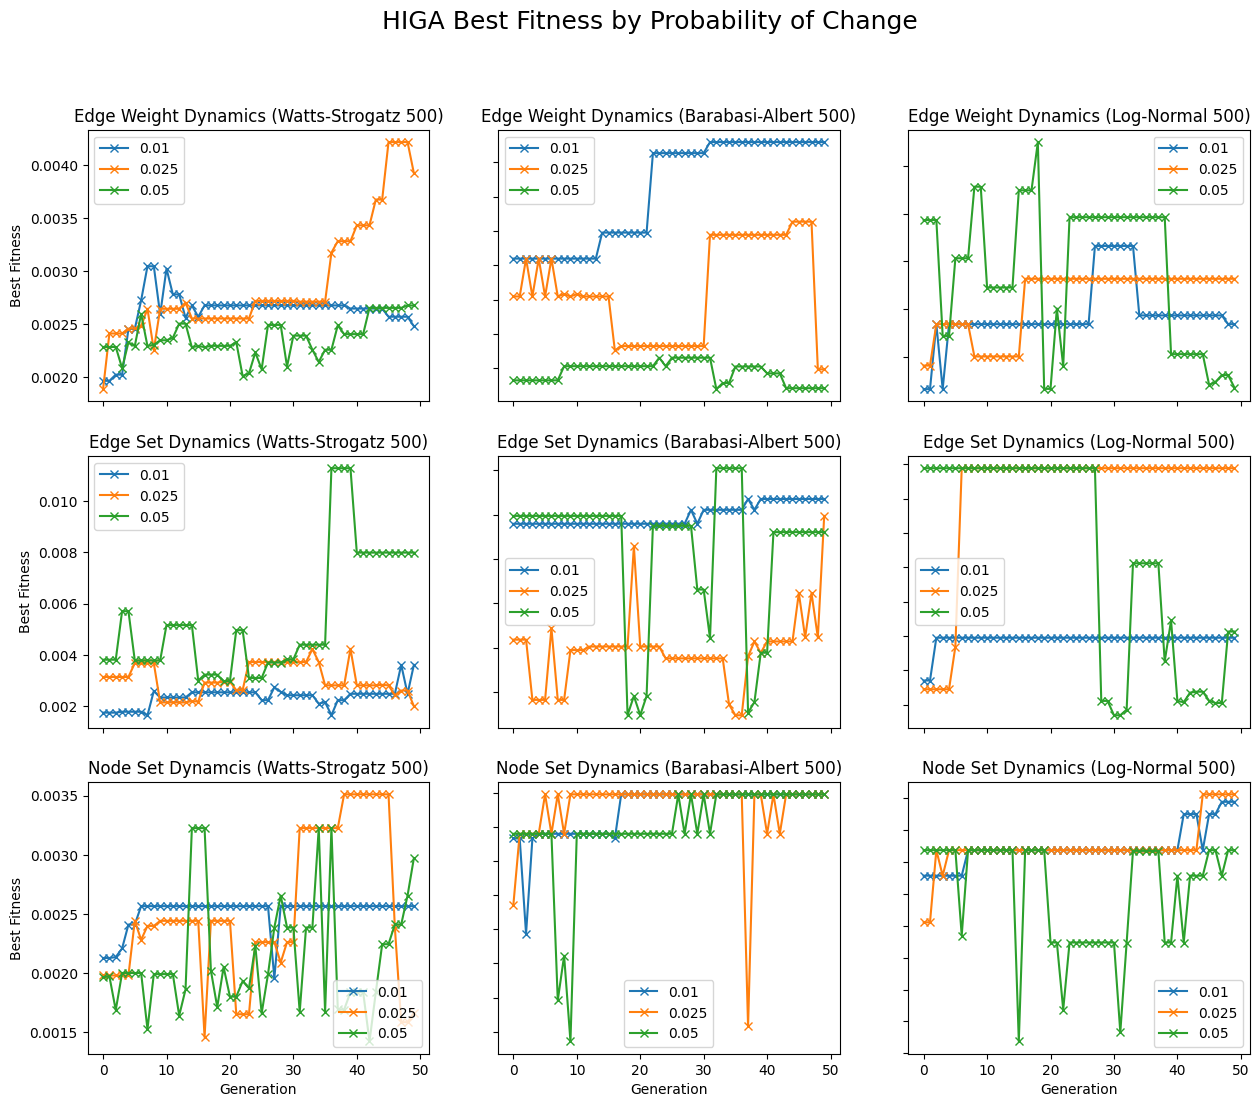

In [53]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('HIGA Best Fitness by Probability of Change',  fontsize = 18)

# First plot (N = 100)
count = 0 
for i in range(3):
    for j in range(3):
        result = results_set[count]
        for x in result:
            axs[i, j].plot(x, marker = "x")
        
        count += 1 

# Make ticks show on outter plot
for ax in fig.get_axes():
    ax.label_outer()
    
axs[0, 0].set_title("Edge Weight Dynamics (Watts-Strogatz 500)")
axs[0, 1].set_title("Edge Weight Dynamics (Barabasi-Albert 500)")
axs[0, 2].set_title("Edge Weight Dynamics (Log-Normal 500)")
axs[1, 0].set_title("Edge Set Dynamics (Watts-Strogatz 500)")
axs[1, 1].set_title("Edge Set Dynamics (Barabasi-Albert 500)")
axs[1, 2].set_title("Edge Set Dynamics (Log-Normal 500)")
axs[2, 0].set_title("Node Set Dynamcis (Watts-Strogatz 500)")
axs[2, 1].set_title("Node Set Dynamics (Barabasi-Albert 500)")
axs[2, 2].set_title("Node Set Dynamics (Log-Normal 500)")

legend_labels = ("0.01", "0.025", "0.05", "0.75", "0.1")
for i in range(3):
    for j in range(3):
        axs[i, j].legend(legend_labels, loc = "best")

axs[2,0].legend(legend_labels, loc = "lower right")
axs[2,2].legend(legend_labels, loc = "lower right")

axs[0, 0].set(ylabel = "Best Fitness")
axs[1, 0].set(ylabel = "Best Fitness")
axs[2, 0].set(ylabel = "Best Fitness")

axs[2, 0].set(xlabel = "Generation")
axs[2, 1].set(xlabel = "Generation")
axs[2, 2].set(xlabel = "Generation")

plt.savefig("./plots/dynamics_probability/exp_1_HIGA_fitness.jpg", dpi = 300)